### REAL TIME FACE DETECTION AND FACE RECOGNITION

**Objective:** Develop a facial recognition system using the LFW dataset to verify if a detected face matches a specific individual. The system integrates a "door animation" that opens for recognized individuals and closes otherwise.

**Key Highlights:**

* Dataset Streaming:

Use TensorFlow Datasets (TFDS) to stream the Labeled Faces in the Wild (LFW) dataset without downloading.
Dynamically preprocess images (resize and normalize).

* Face Verification:

Create positive and negative pairs for training using the LFW dataset.
Train a Siamese Network to measure similarity between faces.

* Door Animation:

Use OpenCV to simulate a real-world response with an "Open Door" or "Close Door" animation based on recognition results.

* Dynamic and Scalable:

Efficient memory usage by streaming data in batches.
Suitable for real-time face verification applications.

    This exercise combines machine learning, computer vision, and real-world applications in an engaging and interactive way. Perfect for beginners exploring face verification or for showcasing a practical AI project!

In [1]:
## Installing Required Libraries
!pip install tensorflow tensorflow-datasets


### Stream The LFW Dataset

In [2]:
!pip install -U tensorflow-datasets


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

# Define a function to preprocess the dataset
def preprocess_image(features):
    image = tf.image.convert_image_dtype(features['image'], tf.float32)  # Normalize to [0, 1]
    label = features['label']
    return image, label

# Load the LFW dataset directly from TensorFlow GCS
train_dataset = tfds.load(
    "lfw",  # Dataset name for LFW (Labeled Faces in the Wild)
    split="train[:5]",  # Load only 5 samples for testing purposes
    as_supervised=False,  # We don't need the labels for direct face recognition tasks
    shuffle_files=True  # Shuffle files for better randomness
)

# Apply preprocessing
train_dataset = train_dataset.map(preprocess_image).batch(5)

# Display dataset information
dataset_info = tfds.builder("lfw").info
print(dataset_info)

# Function to visualize the streamed dataset
def visualize_images(dataset):
    plt.figure(figsize=(10, 5))
    for batch in dataset.take(1):  # Visualize streamed data
        images, labels = batch
        for i in range(images.shape[0]):
            ax = plt.subplot(1, images.shape[0], i + 1)
            plt.imshow(tf.keras.utils.array_to_img(images[i]))  # Convert to displayable format
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")
        break  # Visualize only the first batch
    plt.show()

# Visualize streamed images
visualize_images(train_dataset)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

# Define a function to preprocess the dataset
def preprocess_for_inception(features):
    image = tf.image.resize(features['image'], (299, 299))  # Resize to 299x299
    image = tf.keras.applications.inception_v3.preprocess_input(image)  # Normalize to [-1, 1]
    label = features['label']
    return image, label

# Load the dataset
dataset_builder = tfds.builder("lfw")
dataset_builder.download_and_prepare()

# Create a train dataset
train_dataset = dataset_builder.as_dataset(split='train', as_supervised=False)

# Apply preprocessing for InceptionV3
train_dataset = (
    train_dataset
    .map(preprocess_for_inception, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

# Display dataset info
print(dataset_builder.info)

# Function to visualize preprocessed images
def visualize_images(dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    image_count = 0

    for batch in dataset:  # Each batch contains (images, labels)
        images, labels = batch
        for i in range(images.shape[0]):  # Iterate over the batch
            if image_count >= num_images:
                break

            ax = plt.subplot(1, num_images, image_count + 1)
            # Convert preprocessed image back to [0, 1] for visualization
            display_image = (images[i] + 1.0) / 2.0  # Rescale [-1, 1] to [0, 1]
            plt.imshow(tf.keras.utils.array_to_img(display_image))
            plt.title(labels[i].numpy().decode("utf-8"))
            plt.axis("off")
            image_count += 1

        if image_count >= num_images:
            break

    plt.show()

# Visualize preprocessed images
visualize_images(train_dataset, num_images=5)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

KeyboardInterrupt: 

### Cropping Faces and Preparing Data for Transfer Learning

In [ ]:
import tensorflow_datasets as tfds
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the Haar Cascade
haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the LFW dataset
lfw_dataset = tfds.load('lfw', split='train', as_supervised=False)

# Function to process and detect faces
def detect_faces_from_lfw(sample):
    image = sample['image'].numpy()  # Get the image as a NumPy array
    label = sample['label'].numpy().decode()  # Decode the label

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Detect faces
    faces = haar_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Draw rectangles around detected faces
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Display the image with detections
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()

# Test the function with the first few images
for i, sample in enumerate(lfw_dataset.take(5)):
    detect_faces_from_lfw(sample)


In [ ]:
cropped_faces = []  # To store cropped face images
labels = []  # To store corresponding labels

# Function to crop and save faces
def crop_and_store_faces(sample):
    image = sample['image'].numpy()
    label = sample['label'].numpy().decode()

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Detect faces
    faces = haar_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Crop faces
    for (x, y, w, h) in faces:
        cropped_face = image[y:y+h, x:x+w]
        cropped_faces.append(cropped_face)
        labels.append(label)  # Store the label for this face

# Process all images in the dataset
for sample in lfw_dataset.take(500):  # Limiting to 500 samples for demonstration
    crop_and_store_faces(sample)

# Resize cropped faces to the input size required by InceptionV3 (299x299)
cropped_faces_resized = [
    cv2.resize(face, (299, 299)) for face in cropped_faces
]

# Normalize to [0, 1]
cropped_faces_normalized = np.array(cropped_faces_resized) / 255.0

# Encode labels into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    cropped_faces_normalized, encoded_labels, test_size=0.2, random_state=42
)

print(f"Training data: {x_train.shape}, Validation data: {x_val.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")


## Code: Training the Recognition Model


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32
)


### Face Detection Using OpenCV
1. Load the Haar Cascade


In [ ]:
# Unfreeze some layers of the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    batch_size=32
)


In [ ]:
# Save the model
model.save('face_recognition_model.keras')

# Evaluate on the validation set
val_loss, val_acc = model.evaluate(x_val, y_val)
print(f"Validation Accuracy: {val_acc:.2f}")


In [ ]:
import cv2
import tensorflow as tf
import numpy as np

# Load Haar cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load trained model
model = tf.keras.models.load_model('face_recognition_model.keras')

# Class labels
class_names = ['Barack Obama', 'George Bush', 'Other']


In [ ]:
pip install streamlit

In [ ]:
from PIL import Image, ImageDraw
import streamlit as st

def draw_door(opened):
    img = Image.new("RGB", (500, 300), "white")
    draw = ImageDraw.Draw(img)

    # Door frame
    draw.rectangle([50, 50, 450, 250], outline="black", width=5)

    if opened:
        # Door open
        draw.rectangle([300, 50, 450, 250], fill="white")
        text = "Door Open"
    else:
        # Door closed
        draw.rectangle([50, 50, 450, 250], fill="brown")
        text = "Door Closed"

    draw.text((200, 270), text, fill="black")
    return img


In [ ]:
# Define the app code as a string
app_code = '''
import streamlit as st
from PIL import Image
import cv2
import numpy as np
import tensorflow as tf

# Load Haar cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load trained model
model = tf.keras.models.load_model('face_recognition_model.keras')

# Class labels
class_names = ['Barack Obama', 'George Bush', 'Other']

# Door animation
def draw_door(opened):
    from PIL import Image, ImageDraw
    img = Image.new("RGB", (500, 300), "white")
    draw = ImageDraw.Draw(img)

    # Door frame
    draw.rectangle([50, 50, 450, 250], outline="black", width=5)

    if opened:
        # Door open
        draw.rectangle([300, 50, 450, 250], fill="white")
        text = "Door Open"
    else:
        # Door closed
        draw.rectangle([50, 50, 450, 250], fill="brown")
        text = "Door Closed"

    draw.text((200, 270), text, fill="black")
    return img

st.title("Face Recognition Door System")

# Upload an image
uploaded_file = st.file_uploader("Upload an image", type=["jpg", "png", "jpeg"])

if uploaded_file:
    # Read image
    image = np.array(Image.open(uploaded_file))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Crop and preprocess face
        face = image[y:y + h, x:x + w]
        face = cv2.resize(face, (299, 299))  # Inception V3 input size
        face = np.expand_dims(face, axis=0) / 255.0

        # Predict
        predictions = model.predict(face)
        predicted_label = class_names[np.argmax(predictions)]

        # Draw face box
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(image, predicted_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Door animation
    if predicted_label in ["Barack Obama", "George Bush"]:
        st.image(draw_door(opened=True))
    else:
        st.image(draw_door(opened=False))

    # Display image with annotations
    st.image(image, caption="Processed Image", use_column_width=True)
'''

# Save the app code to a file
with open("app.py", "w") as file:
    file.write(app_code)


In [ ]:
# List of required libraries
requirements = """
streamlit
tensorflow
opencv-python
pillow
numpy
"""

# Write to requirements.txt
with open("requirements.txt", "w") as file:
    file.write(requirements)

print("requirements.txt has been created.")


In [ ]:
# Install Academic Torrents
!pip install academictorrents

import academictorrents as at
import os
import zipfile

# Directory to store the downloaded dataset
dataset_dir = "./yale_faces"

# Ensure the directory exists
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# Torrent hash for the Extended Yale Face Database B
torrent_hash = "06e479f338b56fa5948c40287b66f68236a14612"

# Download the dataset
print("Downloading the dataset...")
dataset_path = at.get(torrent_hash, dataset_dir)
print(f"Dataset downloaded to: {dataset_path}")

# Extract the dataset
if not os.path.exists("./CroppedYale"):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_path, "r") as zip_ref:
        zip_ref.extractall("./")
    print("Extraction complete!")

# Confirm extracted content
print("Content extracted. Listing files...")
!ls -lh ./CroppedYale


In [ ]:
import os
import requests
import zipfile

# Directory to save the dataset
dataset_dir = "/content/WIDER_FACE"
os.makedirs(dataset_dir, exist_ok=True)

def download_file(url, output_path, expected_size=None):
    """Download a file and verify its size."""
    if os.path.exists(output_path):
        print(f"File already exists: {output_path}")
        return

    print(f"Downloading {url}...")
    with requests.get(url, stream=True) as response:
        response.raise_for_status()  # Raise an error for failed downloads
        with open(output_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
    print(f"Download complete: {output_path}")

    # Check file size if expected_size is provided
    if expected_size and os.path.getsize(output_path) != expected_size:
        raise ValueError(f"Downloaded file size does not match the expected size: {expected_size} bytes")

def download_and_unzip(url, output_dir, expected_size=None):
    """Download and unzip a file from the given URL."""
    filename = os.path.join(output_dir, url.split("/")[-1])
    extracted_dir = filename.replace(".zip", "")

    # Check if the file is already extracted
    if os.path.exists(extracted_dir):
        print(f"Data already extracted: {extracted_dir}")
        return

    # Download file
    download_file(url, filename, expected_size)

    # Unzip the file
    print(f"Extracting {filename}...")
    try:
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
        print(f"Extraction complete: {extracted_dir}")
    except zipfile.BadZipFile:
        print(f"Error: {filename} is not a valid zip file. Please redownload.")
        raise

# URLs for the WIDER FACE dataset
wider_face_train_url = "http://shuoyang1213.me/WIDERFACE/WIDER_train.zip"
wider_face_val_url = "http://shuoyang1213.me/WIDERFACE/WIDER_val.zip"
wider_face_anno_url = "http://shuoyang1213.me/WIDERFACE/wider_face_split.zip"

# Expected file sizes in bytes
expected_sizes = {
    wider_face_train_url: 11000000000,  # ~11 GB
    wider_face_val_url: 1400000000,    # ~1.4 GB
    wider_face_anno_url: 20000000      # ~20 MB
}

# Download and unzip each dataset
for url, expected_size in expected_sizes.items():
    download_and_unzip(url, dataset_dir, expected_size)

print("All files downloaded and extracted successfully!")


In [ ]:

import zipfile
import os

# Path to the ZIP file
zip_path = "/content/WIDER_FACE/WIDER_val.zip"

# Directory to extract the contents
extract_dir = "/content/WIDER_FACE/WIDER_val"

# Check if the file is a valid ZIP
if zipfile.is_zipfile(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Extract all contents
        zip_ref.extractall(extract_dir)
        print(f"Extracted files to {extract_dir}")
else:
    print(f"The file at {zip_path} is not a valid ZIP file.")






In [3]:
import tensorflow as tf
import tensorflow_hub as hub

# Define the model URL from TensorFlow Hub
model_url = "https://tfhub.dev/google/facenet/1"  # FaceNet URL on TensorFlow Hub

# Load the FaceNet model from TensorFlow Hub
facenet_layer = hub.KerasLayer(model_url, input_shape=(160, 160, 3), trainable=False)

# Wrap it in a Keras Model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(160, 160, 3)),
    tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (160, 160))),  # Ensure correct input size
    tf.keras.layers.Lambda(lambda x: x / 255.0),  # Normalize to [0, 1]
    facenet_layer  # Add the FaceNet layer
])

# Save the model locally as a .h5 file
model.save("facenet_model.h5")
print("FaceNet model saved as 'facenet_model.h5'")


OSError: https://tfhub.dev/google/facenet/1 does not appear to be a valid module.

In [2]:
print("Output keys:", inference_fn.structured_outputs)


Output keys: {'Bottleneck_BatchNorm': TensorSpec(shape=(None, 128), dtype=tf.float32, name='bottleneck_batchnorm')}


In [8]:
import tensorflow as tf
import numpy as np

# Load FaceNet model (SavedModel format)
path = kagglehub.model_download("faiqueali/facenet-tensorflow/tensorFlow2/default") # Path to the downloaded FaceNet model directory
model = tf.saved_model.load(path)
inference_fn = model.signatures["serving_default"]

# Preprocess the image to (160, 160, 3)
def preprocess_image(image_path):
    """Preprocesses an image for FaceNet model."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [160, 160])
    image = (image - 127.5) / 128.0  # Normalize to [-1, 1]
    return tf.expand_dims(image, axis=0)  # Add batch dimension

# Generate embeddings for the image
def get_embeddings(image_path, model_fn):
    """Generates embeddings for the given image using FaceNet model."""
    preprocessed_image = preprocess_image(image_path)
    output_key = "Bottleneck_BatchNorm"
    embeddings = model_fn(preprocessed_image)[output_key].numpy()
    return embeddings

# Generate embeddings for Obama's and George Bush's face images
obama_image_path = "/content/President_Barack_Obama.jpg"
george_bush_image_path = "/content/George-W-Bush.jpeg"

# Generate embeddings
obama_embeddings = get_embeddings(obama_image_path, inference_fn)
george_bush_embeddings = get_embeddings(george_bush_image_path, inference_fn)

# Save embeddings to files for later use
np.save("/content/obama_embedding.npy", obama_embeddings)
np.save("/content/george_bush_embedding.npy", george_bush_embeddings)

print("Obama's Embeddings:", obama_embeddings)
print("George Bush's Embeddings:", george_bush_embeddings)


Obama's Embeddings: [[-0.30730903 -0.5185212   0.04042654 -0.636709    0.36357635  0.1395215
  -0.11546929  0.09607683  0.09490836  0.06800409  0.676181   -0.09217558
   0.155042   -0.695616   -0.48593882  0.32158577  0.2547813  -0.08169039
   0.48670205 -0.80386305 -0.03750779 -0.07195354 -0.0554002   0.22305462
   0.13804811 -0.08729931  0.59129524  0.511312   -0.33582157 -0.11547387
  -0.39991745  0.12499699  0.05516692 -0.33311027  0.3454303   0.06130062
   0.18239766  0.6233976   0.6051498   0.25385714  0.4449319  -0.04479422
   0.38814434 -0.03176819 -0.24797143 -0.68187284 -0.0329594  -0.34400186
   0.6627476   0.07228717 -0.3437959   0.67420876  0.5726413  -0.46156883
  -0.08397959  0.95013237 -0.11241575 -0.12906526 -0.30507052 -0.53136957
  -0.36229745 -0.2960699  -0.01912288  0.24248064 -0.1800527   0.45416927
   0.03340476  0.18624    -0.11948866 -0.31664833 -0.06200713 -0.03938653
   0.225666   -0.5334574  -0.03159364 -0.39551136 -0.48927903  0.42678082
  -0.43009606 -0.43

In [11]:
import kagglehub
import tensorflow as tf
import numpy as np

# Step 1: Download the FaceNet model from Kaggle
path = kagglehub.model_download("faiqueali/facenet-tensorflow/tensorFlow2/default")
print("Path to model files:", path)

# Model directory (contains saved_model.pb)
model_dir = path

# Step 2: Load the FaceNet model (SavedModel format)
model = tf.saved_model.load(model_dir)
print("Model loaded successfully!")

# Check available signatures (for debugging)
print("Available signatures:", model.signatures.keys())

# Get the default signature for inference
inference_fn = model.signatures["serving_default"]

# Step 3: Preprocess an image
def preprocess_image(image_path):
    """Preprocesses an image for FaceNet model."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [160, 160])
    image = (image - 127.5) / 128.0  # Normalize the image to [-1, 1]
    return tf.expand_dims(image, axis=0)  # Add batch dimension

# Step 4: Generate embeddings for a face image
def get_embeddings(image_path, model_fn):
    """Generates embeddings for the given image."""
    preprocessed_image = preprocess_image(image_path)
    # Use the correct output key: 'Bottleneck_BatchNorm'
    output_key = "Bottleneck_BatchNorm"
    embeddings = model_fn(preprocessed_image)[output_key].numpy()
    return embeddings

# Example usage:
image_path = "/content/test_other_face.jpg"  # Replace with a valid image path
embeddings = get_embeddings(image_path, inference_fn)
print("Generated Embeddings:", embeddings)

# Step 5: Compare with known embeddings
def euclidean_distance(emb1, emb2):
    """Calculates the Euclidean distance between two embeddings."""
    return np.linalg.norm(emb1 - emb2)

# Load or define known embeddings (example for George Bush and Barack Obama)
known_embeddings = {
    "obama": np.load("/content/obama_embedding.npy"),  # Replace with actual path
    "george_bush": np.load("/content/george_bush_embedding.npy"),  # Replace with actual path
}

# Reshape them to match FaceNet output (128-dimensional)
known_embeddings_resized = {
    name: embedding[:128]  # Slice to first 128 values, make sure this is necessary for your embeddings
    for name, embedding in known_embeddings.items()
}

# Compare the new embeddings with known embeddings
threshold =  3.0  # Set a suitable threshold
for name, known_emb in known_embeddings_resized.items():  # Make sure to use the resized embeddings
    distance = euclidean_distance(embeddings, known_emb)
    print(f"Distance to {name}: {distance}")
    if distance < threshold:
        print(f"Match found: {name}")


Path to model files: /root/.cache/kagglehub/models/faiqueali/facenet-tensorflow/tensorFlow2/default/2
Model loaded successfully!
Available signatures: KeysView(_SignatureMap({'serving_default': <ConcreteFunction (*, input_1: TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='input_1')) -> Dict[['Bottleneck_BatchNorm', TensorSpec(shape=(None, 128), dtype=tf.float32, name='bottleneck_batchnorm')]] at 0x7FE92BA526B0>}))
Generated Embeddings: [[-0.7439599   0.01987619  0.11351236  0.9226208  -0.20143886  1.2588432
  -0.77334225  0.2847045  -1.0553857   0.5884038  -0.35220426  0.13372621
   1.3631575   0.8008647   0.2809532   0.10117839  1.7962414  -1.2318313
   0.5514575   1.3170254   0.870244   -0.07338082 -1.0846262   0.76542705
  -0.2520185  -0.31243613 -0.75965667  0.9040388   0.5047433  -0.09471909
   1.1444623   0.37892085  0.09066951  0.14334098 -0.10509997 -0.8443175
   0.2514651  -1.0225569  -1.049124    0.91452026  0.48541626  0.64859605
   0.41781127  0.4056717  -0.75

Distance to Barack Obama: 12.587328910827637
Distance to George Bush: 14.057645797729492
Animation: Door stays closed.


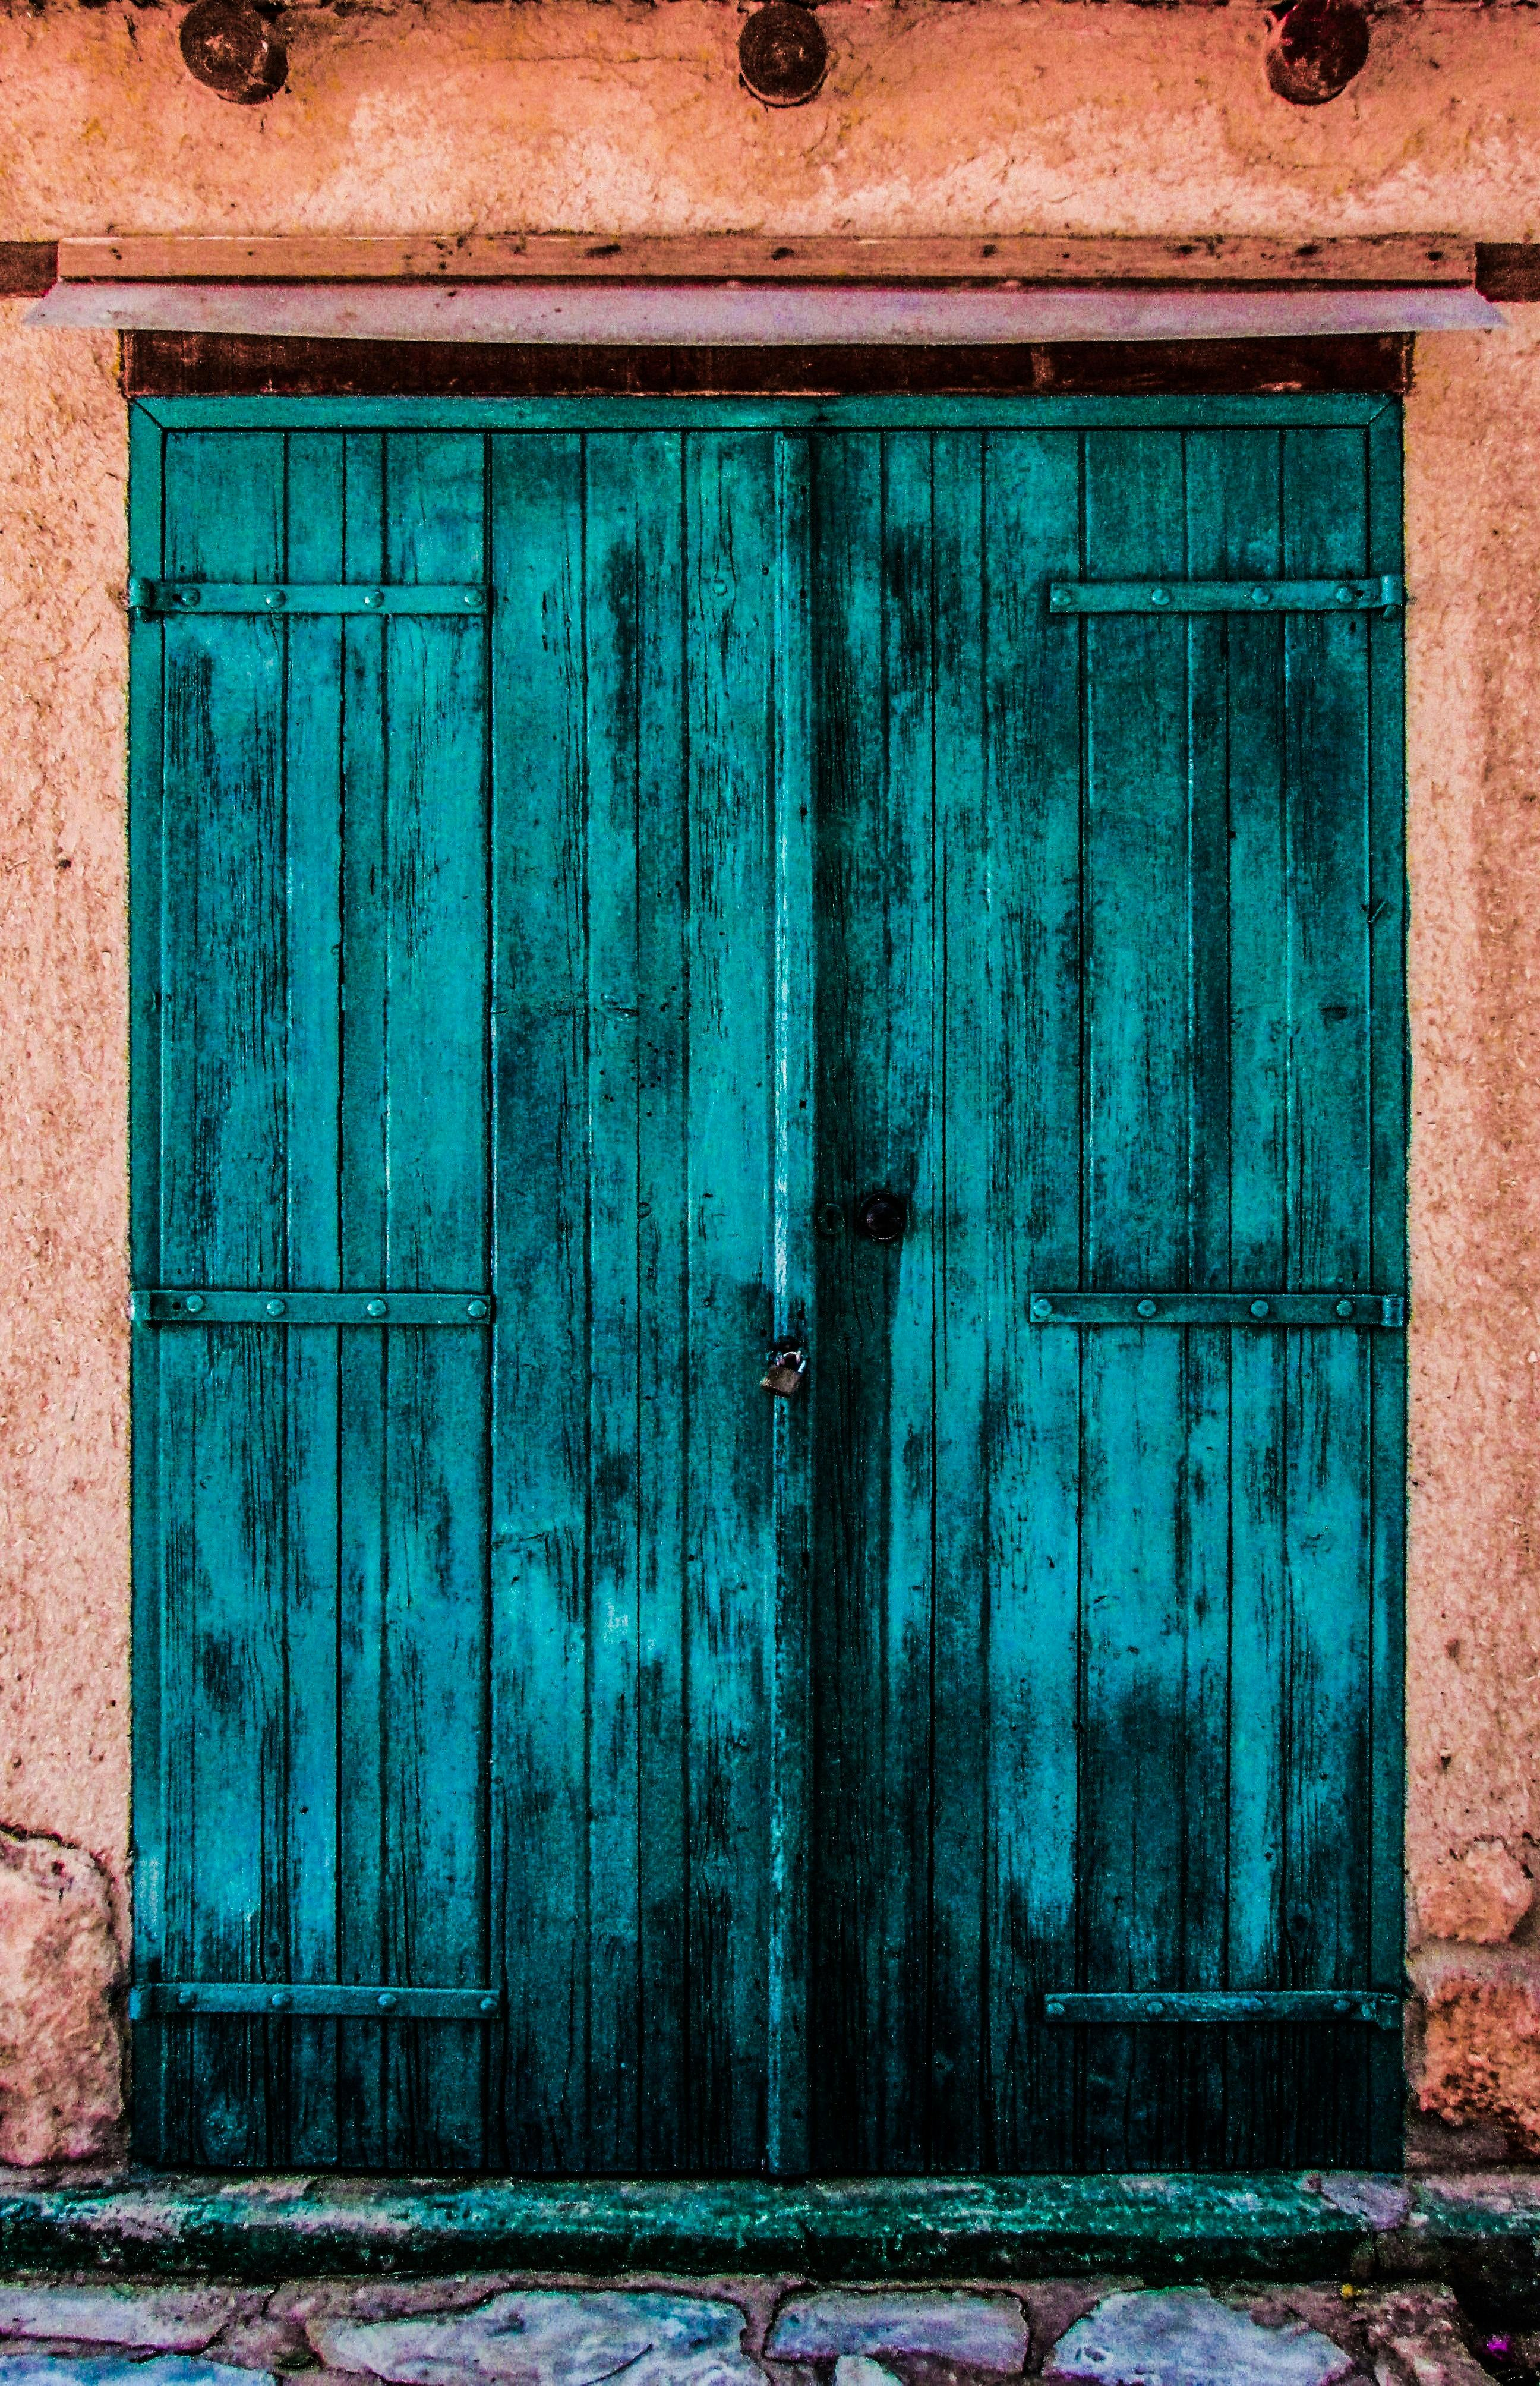

In [20]:
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
from IPython.display import display, Image as ColabImage

# Load Haar Cascade model for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load FaceNet model
model_path = '/root/.cache/kagglehub/models/faiqueali/facenet-tensorflow/tensorFlow2/default/2'
model = tf.saved_model.load(model_path)
inference_fn = model.signatures["serving_default"]

# Precomputed embeddings for Barack Obama and George Bush
obama_embeddings = np.load("/content/obama_embedding.npy")
george_bush_embeddings = np.load("/content/george_bush_embedding.npy")

known_embeddings = {
    "Barack Obama": obama_embeddings,
    "George Bush": george_bush_embeddings
}

def preprocess_image(image):
    """Preprocess an image for the FaceNet model."""
    image = cv2.resize(image, (160, 160))  # Resize to 160x160
    image = (image - 127.5) / 128.0  # Normalize to [-1, 1]
    return np.expand_dims(image, axis=0)  # Add batch dimension

def euclidean_distance(emb1, emb2):
    """Calculate Euclidean distance between two embeddings."""
    return np.linalg.norm(emb1 - emb2)

def detect_faces(image):
    """Detect faces in the image using Haar Cascade."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

def get_embeddings(face, model_fn):
    """Generate embeddings for a given face."""
    preprocessed_face = preprocess_image(face)
    output_key = "Bottleneck_BatchNorm"
    embeddings = model_fn(tf.convert_to_tensor(preprocessed_face, dtype=tf.float32))[output_key].numpy()
    return embeddings

def display_door_animation(is_open):
    """Display the door animation in Colab."""
    if is_open:
        print("Animation: Door opens!")
        door_image_path = "/content/pexels-chelsea-cook-1520634-2929910.jpg"  # Path to the 'door open' image
    else:
        print("Animation: Door stays closed.")
        door_image_path = "/content/pexels-pixabay-277509.jpg"  # Path to the 'door closed' image

    # Display the image in Colab
    display(ColabImage(filename=door_image_path))

def recognize_face(image):
    """Recognize face and trigger door animation."""
    faces = detect_faces(image)
    if len(faces) == 0:
        print("No face detected!")
        display_door_animation(False)
        return

    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]  # Crop the face
        embeddings = get_embeddings(face, inference_fn)

        # Compare embeddings
        threshold = 10.0  # Adjust based on embedding distances
        match_found = False
        for name, known_emb in known_embeddings.items():
            distance = euclidean_distance(embeddings, known_emb)
            print(f"Distance to {name}: {distance}")
            if distance < threshold:
                print(f"Match found: {name}")
                match_found = True
                break

        if match_found:
            display_door_animation(True)
        else:
            display_door_animation(False)

# Example usage
if __name__ == "__main__":
    # Load the test image
    image_path = "/content/test_other_face.jpg"
    image = cv2.imread(image_path)

    if image is None:
        print("Error: Image not found or path is incorrect.")
    else:
        recognize_face(image)


In [18]:
pip install opencv-python-headless numpy tensorflow matplotlib pillow


In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import cv2
import numpy as np
import tensorflow as tf
import time

# Load Haar Cascade model for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load FaceNet model
model_path = '/root/.cache/kagglehub/models/faiqueali/facenet-tensorflow/tensorFlow2/default/2'
model = tf.saved_model.load(model_path)
inference_fn = model.signatures["serving_default"]

# Load known embeddings (Barack Obama, George Bush)
obama_embeddings = np.load("/content/obama_embedding.npy", allow_pickle=True)
george_bush_embeddings = np.load("/content/george_bush_embedding.npy", allow_pickle=True)

known_embeddings = {
    "Barack Obama": obama_embeddings,
    "George Bush": george_bush_embeddings
}

# Functions for face recognition
def preprocess_image(image):
    """Preprocesses an image for FaceNet model."""
    image = cv2.resize(image, (160, 160))  # Resize to 160x160
    image = (image - 127.5) / 128.0       # Normalize to [-1, 1]
    return np.expand_dims(image, axis=0)  # Add batch dimension

def euclidean_distance(emb1, emb2):
    """Calculate Euclidean distance between two embeddings."""
    return np.linalg.norm(emb1 - emb2)

def detect_faces(image):
    """Detect faces using Haar Cascade."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

def get_embeddings(face_image):
    """Generate embeddings for a face."""
    preprocessed_image = preprocess_image(face_image)
    embeddings = inference_fn(tf.constant(preprocessed_image, dtype=tf.float32))["Bottleneck_BatchNorm"].numpy()
    return embeddings

def recognize_face(image):
    """Recognize face in the image and return results."""
    faces = detect_faces(image)
    if len(faces) == 0:
        return None, "No face detected!"

    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]  # Crop the face
        embeddings = get_embeddings(face)

        # Compare embeddings with known ones
        threshold = 1.0
        for name, known_emb in known_embeddings.items():
            distance = euclidean_distance(embeddings, known_emb)
            if distance < threshold:
                return name, "Match found: " + name

    return None, "No match found!"

# Tkinter GUI
def upload_and_recognize():
    """Handle the image upload and recognition process."""
    global panel, door_label

    # Open file dialog
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")])
    if not file_path:
        return

    # Read and display the image
    image = cv2.imread(file_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for PIL
    image_pil = Image.fromarray(image_rgb)
    img_tk = ImageTk.PhotoImage(image_pil)

    panel.config(image=img_tk)
    panel.image = img_tk

    # Recognize the face
    name, result = recognize_face(image)

    # Update result label
    result_label.config(text=result)

    # Show door animation based on recognition
    if name:
        door_label.config(image=door_open_img)
        door_label.image = door_open_img
    else:
        door_label.config(image=door_closed_img)
        door_label.image = door_closed_img

# Create main Tkinter window
root = tk.Tk()
root.title("Face Recognition - Door Opener")

# Upload button
upload_button = tk.Button(root, text="Upload Image", command=upload_and_recognize)
upload_button.pack()

# Panel to display the image
panel = tk.Label(root)
panel.pack()

# Result label
result_label = tk.Label(root, text="", font=("Helvetica", 16))
result_label.pack()

# Door animation label
door_open_img = ImageTk.PhotoImage(Image.open("door_open.jpg").resize((200, 400)))  # Replace with your image
door_closed_img = ImageTk.PhotoImage(Image.open("door_closed.jpg").resize((200, 400)))  # Replace with your image
door_label = tk.Label(root, image=door_closed_img)
door_label.pack()

# Start the Tkinter event loop
root.mainloop()
